# I. Imports and Configurations

In [404]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from IPython.display import display, Image
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
ecm = make_scorer(mean_absolute_error)
ecm_name = 'mean_absolute_error'
k_fold_value = 5

raw_dataset = pd.read_csv('dataset.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

predictors = ['SampleNo', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# II. Functions and Classes

In [405]:
# Utility Classes
class ModelResult:
    def __init__(self, info_dict: dict):
        self.model = info_dict['model']
        self.arg = info_dict['arg']
        self.predictors = info_dict['predictors']
        self.predicted = info_dict['predicted']
        self.error = info_dict['error']
        if 'estimator' in info_dict.keys():
            self.estimator = info_dict['estimator']


class ModelResultsTable:
    def __init__(self):
        self.all_model_results = {}  # {'mul_lin_reg': [ModelResult0, ModelResult1, ...], 'lin_reg': [...] ... }
        self.model_results_with_best_params = []

    def add_model(self, model_results: list):
        sorted_models = list(sorted(model_results, key=lambda item: item.error))
        best_performing_var = sorted_models[0]
        self.all_model_results[best_performing_var.model] = sorted_models
        self.model_results_with_best_params.append(best_performing_var)
        self.model_results_with_best_params = list(sorted(self.model_results_with_best_params,
                                                          key=lambda item: item.error))

    def display_error_table(self, transpose=True, model=None):
        if model is not None:
            arg_indexes = [model_result.arg for model_result in self.all_model_results[model]]
            error_table = pd.DataFrame([[result.predictors, result.error]
                                        for result in self.all_model_results[model]],
                                       columns=['predictors', ecm_name], index=arg_indexes)
        else:
            model_indexes = [model_result.model for model_result in self.model_results_with_best_params]
            error_table = pd.DataFrame([[result.arg, result.predictors, result.error]
                                        for result in self.model_results_with_best_params],
                                       columns=['args', 'predictors', ecm_name], index=model_indexes)
        if transpose:
            error_table = error_table.transpose()
        display(error_table)


# Utility Functions
def plot_conditional_models(cond_models, cond_sets, plot_titles):
    fig_ = plt.figure(figsize=(18, 5))
    cv_error = 0
    plot_i = 1
    decision_df = pd.DataFrame(columns=['Model', 'Predictors', 'Args', 'Error'])

    for cond_model, cond_set, plot_title in zip(cond_models, cond_sets, plot_titles):
        decision_df.loc[plot_title] = [cond_model.model, cond_model.predictors,
                                       cond_model.arg, cond_model.error]

        if len(cond_model.predictors) == 1:
            ax = fig_.add_subplot(1, 3, plot_i)
            sns.scatterplot(ax=ax, x=cond_set[cond_model.predictors[0]], y=cond_set['Y'],
                            color='b', label='Actual Data')
            sns.scatterplot(ax=ax, x=cond_set[cond_model.predictors[0]], y=cond_model.predicted,
                            color='r', label='Predicted')
            ax.set_title(plot_title)
        elif len(cond_model.predictors) == 2:
            ax = fig_.add_subplot(1, 3, plot_i, projection='3d')
            ax.view_init(elev=2., azim=-96)
            ax.set_box_aspect(aspect=None, zoom=1.35)

            x_axis = cond_model.predictors[0]
            y_axis = cond_model.predictors[1]
            z_axis = 'Y'

            ax.scatter(cond_set[x_axis],
                       cond_set[y_axis],
                       cond_set[z_axis],
                       c=cond_set[z_axis])
            ax.plot_trisurf(cond_set[x_axis],
                            cond_set[y_axis],
                            cond_model.predicted,
                            linewidth=0, antialiased=True, alpha=0.3, color='r')
            ax.set_xlabel(x_axis)
            ax.set_ylabel(y_axis)
            ax.set_zlabel(z_axis)
            ax.set_title(plot_title)
        else:
            pass

        cv_error += cond_model.error
        plot_i += 1

    print('Total CV Score (MAE) =', cv_error)
    display(decision_df)


def subplot_for_five(data, title=None, highlight=None, reg_plot=None):
    point_colors = ['b', 'b', 'b', 'b', 'b']
    if highlight is not None:
        point_colors[highlight] = 'r'
    fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
    fig_.suptitle(title, fontsize=20)

    axes_[1][2].set_visible(False)
    axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
    axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

    if reg_plot is not None:
        for i in range(len(predictors)):
            sns.scatterplot(ax=axes_[i // 3, i % 3], x=data[predictors[i]], y=data['Y'],
                            alpha=0.5, color=point_colors[i])
            sns.regplot(ax=axes_[i // 3, i % 3], x=data[predictors[i]], y=reg_plot[i].predicted,
                        color='r', scatter=False, label='Predicted Y')
    else:
        for i in range(len(predictors)):
            sns.scatterplot(ax=axes_[i // 3, i % 3], x=data[predictors[i]], y=data['Y'],
                            alpha=0.5, color=point_colors[i])


def split_by_threshold(ss, predictor, threshold):
    return ss[ss[predictor] < threshold], ss[ss[predictor] >= threshold]


def get_decision_sets(source_set, conditions):
    return_set = []
    sample_set = source_set.copy()
    for condition in conditions:
        if condition == conditions[-1]:
            return_set.append(sample_set)
            break
        predictor, operator, threshold = condition[:2], condition[2], int(condition[3:])
        lt, gt = split_by_threshold(sample_set, predictor, threshold)
        if operator == '<':
            return_set.append(lt)
            sample_set = gt
        else:
            return_set.append(gt)
            sample_set = lt
    return return_set


def get_decision_models(source_set, conditions, return_sets=False):
    decisions = []
    conditional_sets = get_decision_sets(source_set, [condition['condition'] for condition in conditions])
    for cond_set, cond in zip(conditional_sets, conditions):
        regression_model = cond['model'](x=cond_set[cond['predictors']],
                                         y=cond_set['Y'],
                                         inputs=cond['predictors'], arg=cond['arg'],
                                         keep_estimator=True)
        decisions.append(regression_model)
    if return_sets:
        return decisions, conditional_sets
    return decisions


# Regression Functions
def single_linear_regression(x, y, arg=None, inputs=None, keep_estimator=False):
    estimator = None
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=x,
                                y=y,
                                cv=5,
                                scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=x,
                                       y=y,
                                       cv=5)
    if keep_estimator:
        estimator = LinearRegression()
        estimator.fit(x, y)
    return ModelResult({'model': 'single_linear_regression',
                        'arg': '',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def multiple_linear_regression(x, y, arg=None, inputs=None, keep_estimator=False):
    estimator = LinearRegression()
    cv_scores = cross_val_score(estimator=estimator,
                                X=x[inputs],
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=x[inputs],
                                       y=y,
                                       cv=5)
    if keep_estimator:
        estimator.fit(x, y)
    return ModelResult({'model': 'multiple_linear_regression',
                        'arg': '',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def polynomial_regression(x, y, arg=None, inputs=None, keep_estimator=False):
    estimator = None
    poly_features = PolynomialFeatures(degree=arg, include_bias=False).fit_transform(x)
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=poly_features,
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=poly_features,
                                       y=y,
                                       cv=5)
    if keep_estimator:
        estimator = LinearRegression()
        estimator.fit(poly_features, y)
    return ModelResult({'model': 'polynomial_regression',
                        'arg': f'order={arg}',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def k_nearest_regression(x, y, arg=5, inputs=None):
    knn_regressor = KNeighborsRegressor(n_neighbors=arg)
    cv_scores = cross_val_score(estimator=knn_regressor,
                                X=x,
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=knn_regressor,
                                       X=x,
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'k_nearest_regression',
                        'arg': f'k={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores)})


def decision_tree_regression(x, y, arg=5, inputs=predictors):
    tree_regressor = DecisionTreeRegressor(random_state=0, max_depth=arg)
    cv_scores = cross_val_score(estimator=tree_regressor,
                                X=x[inputs],
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=tree_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'decision_tree_regression',
                        'arg': f'max_depth={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores)})


def random_forest_regression(x, y, arg=None, inputs=predictors):
    tree_regressor = RandomForestRegressor(max_depth=arg, random_state=0, max_features=len(inputs))
    cv_scores = cross_val_score(estimator=tree_regressor,
                                X=x[inputs],
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=tree_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'random_forest_regression',
                        'arg': f'max_depth={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores)})


all_results_table = ModelResultsTable()

# III. Introduction and Insights

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

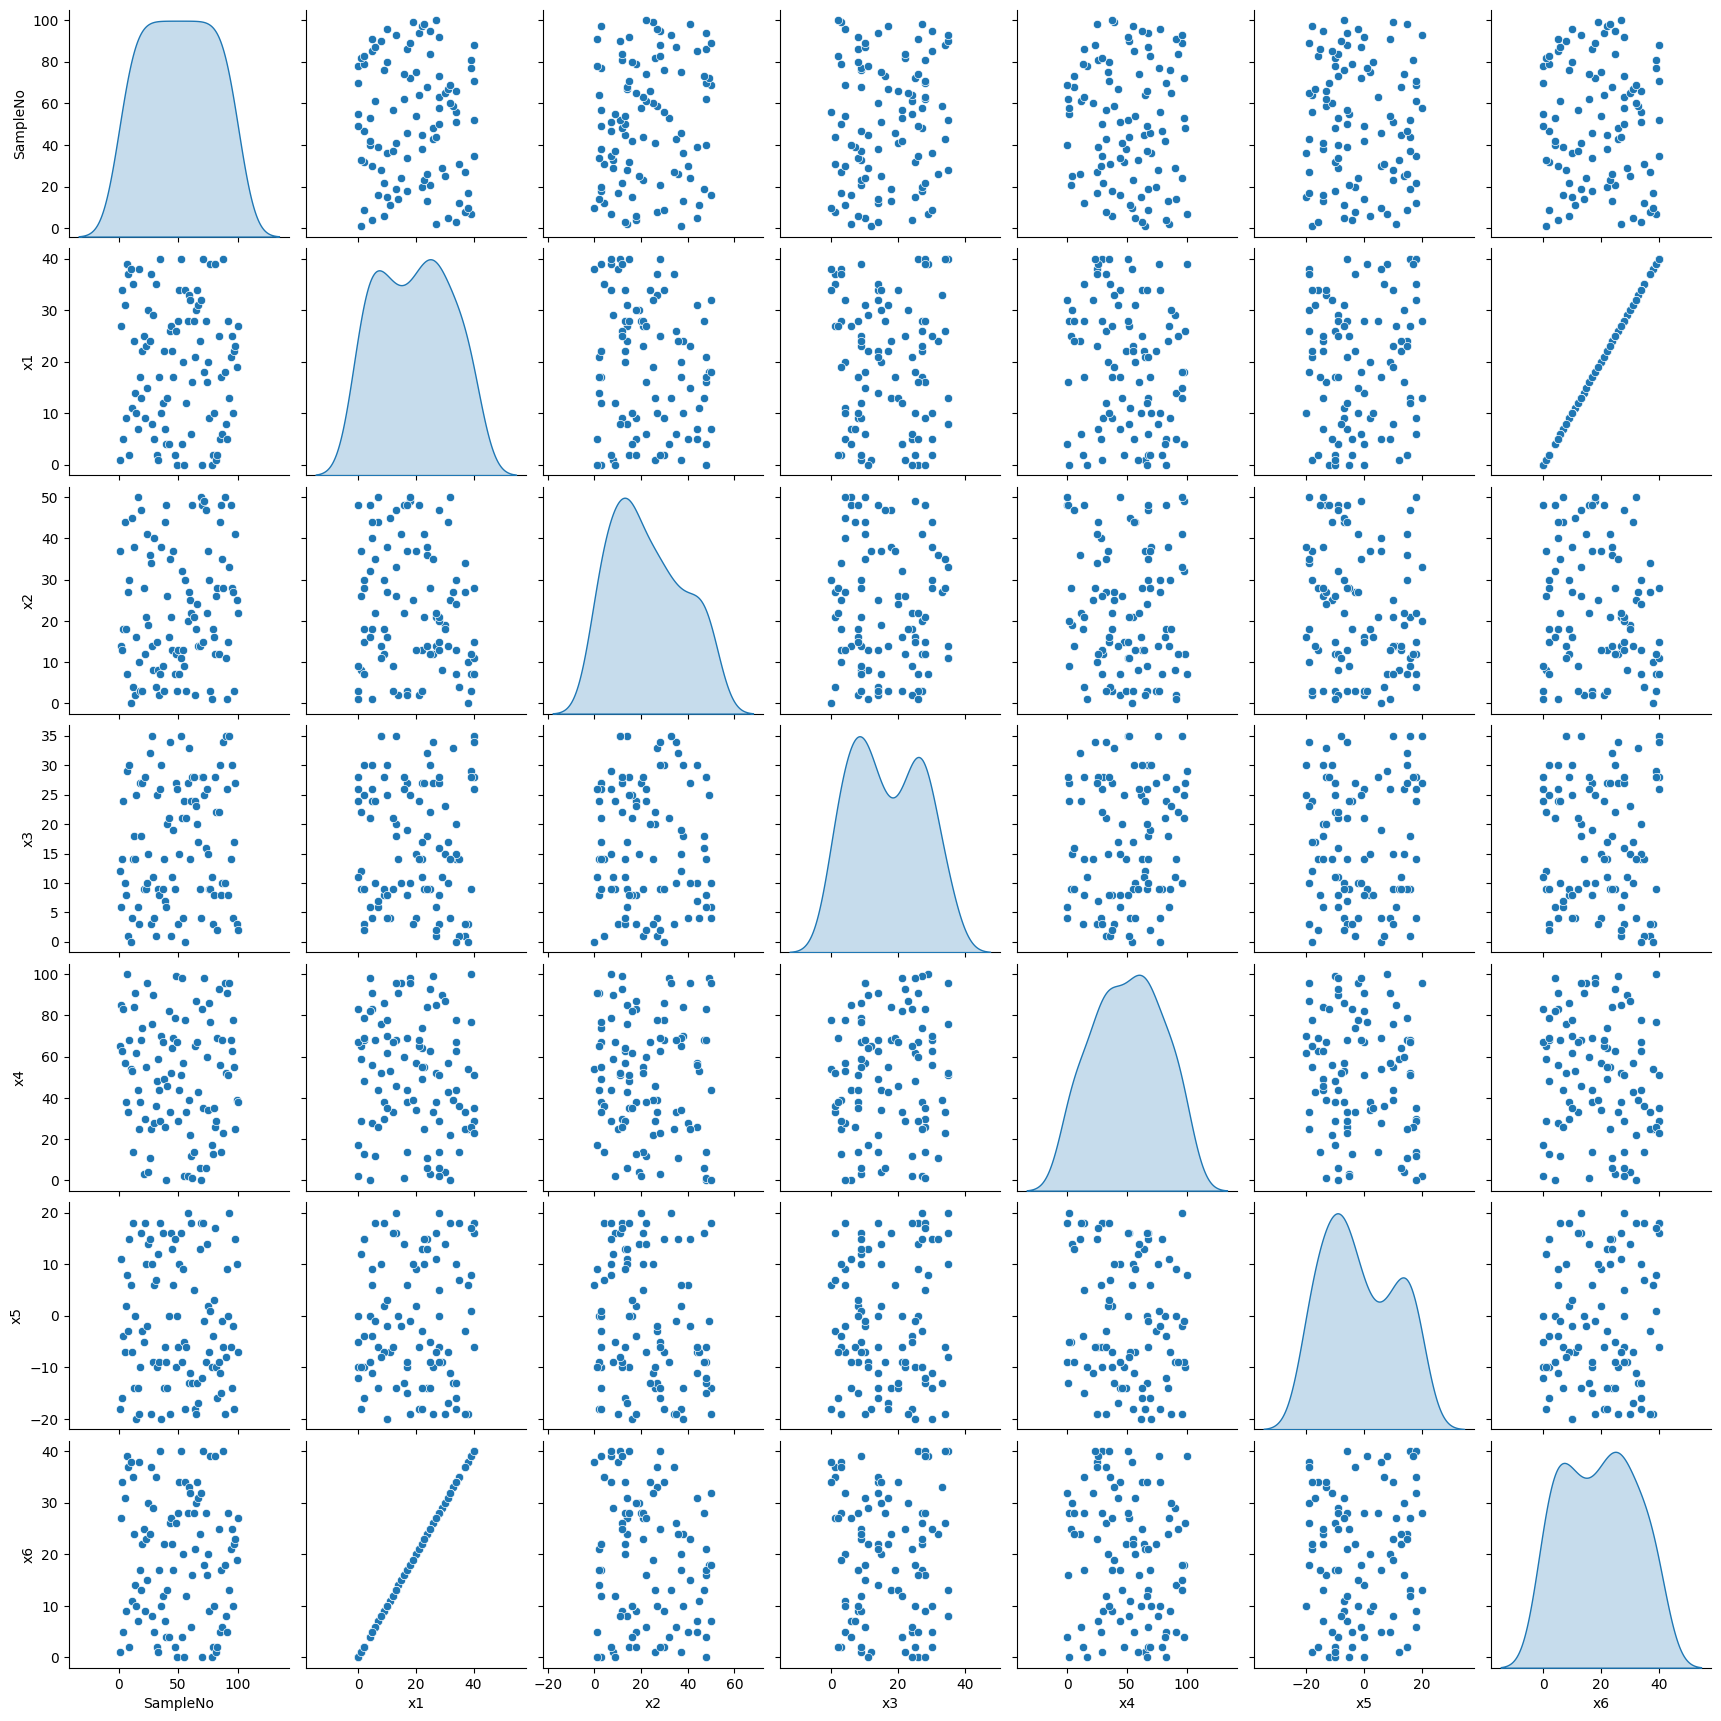

In [406]:
sns.pairplot(dataset[predictors], diag_kind='kde')

From looking at those results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same values twice. Also, I have previously included SampleNo as a predictor (even it is
not really logical) just to see if it makes the algorithms perform better, which it obviously did not. So, I am also
dropping the SampleNo from the dataset and the predictors list.

In [407]:
dataset = dataset.drop('x6', axis=1)
predictors.remove('x6')

dataset = dataset.drop('SampleNo', axis=1)
predictors.remove('SampleNo')

features, labels = dataset[predictors], dataset['Y']

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

,min,max,mean,std
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


Then, I wanted to see how each of the remaining predictors relate to Y separately.

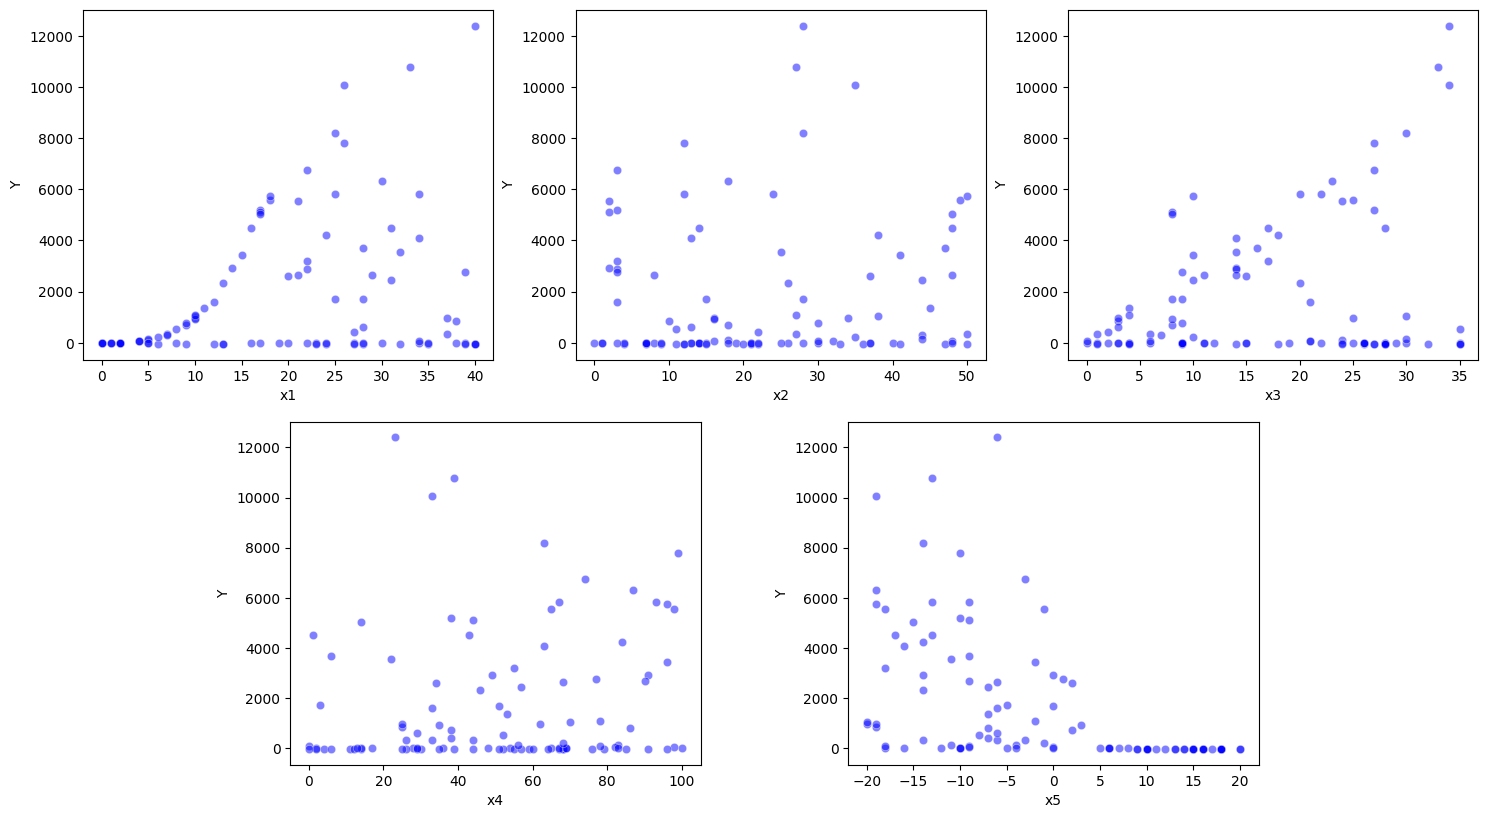

In [408]:
subplot_for_five(dataset)

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be lower. Similarly,
when x5 has a value greater than 5, its corresponding Y value is lower. Because of this, I assumed that some kind of
threshold should separate those plots.

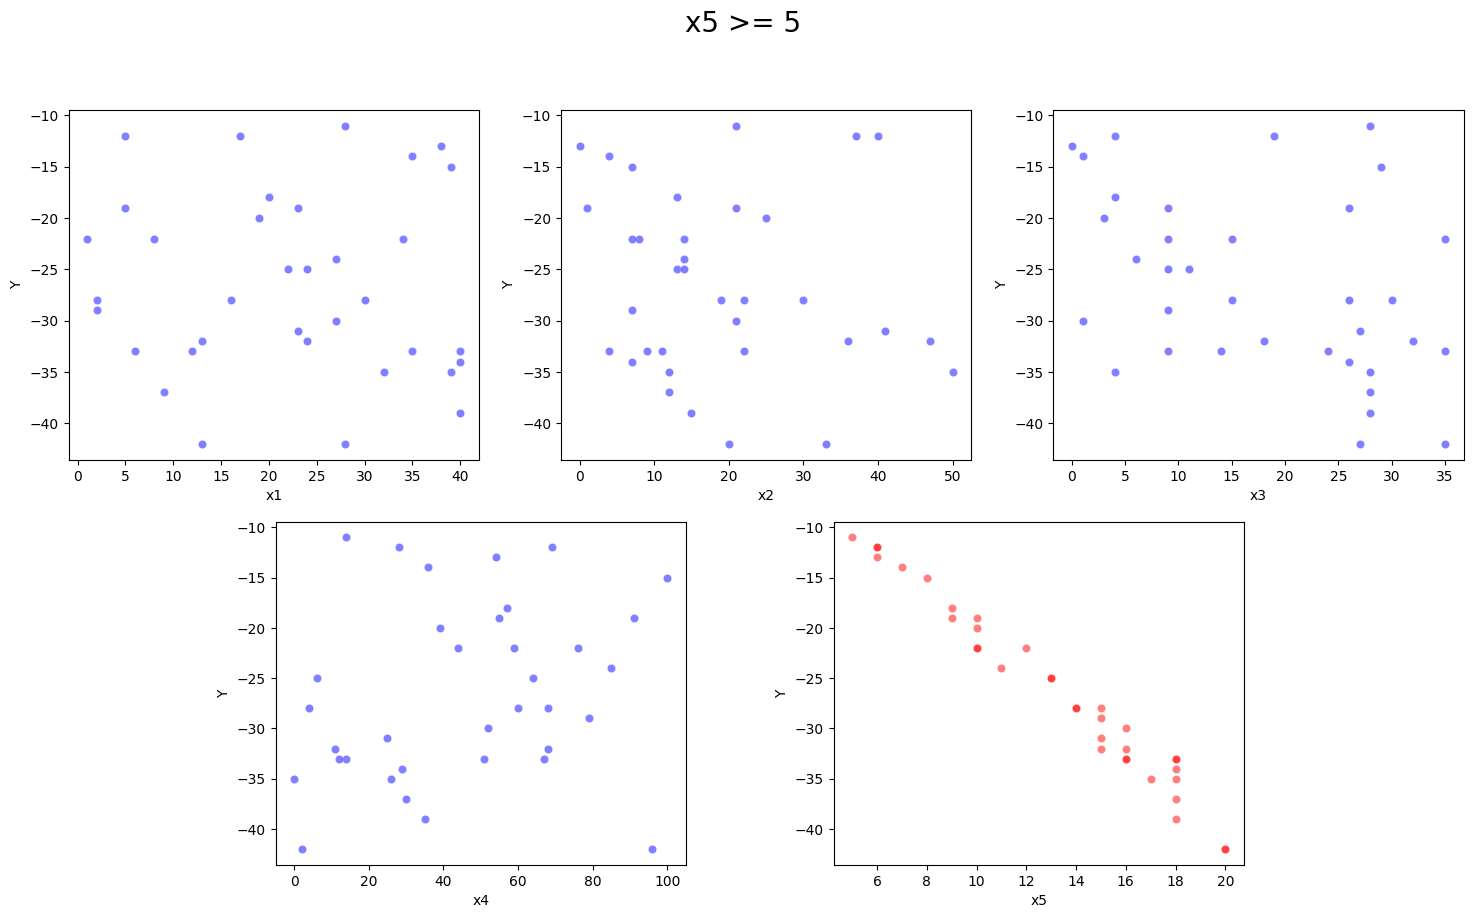

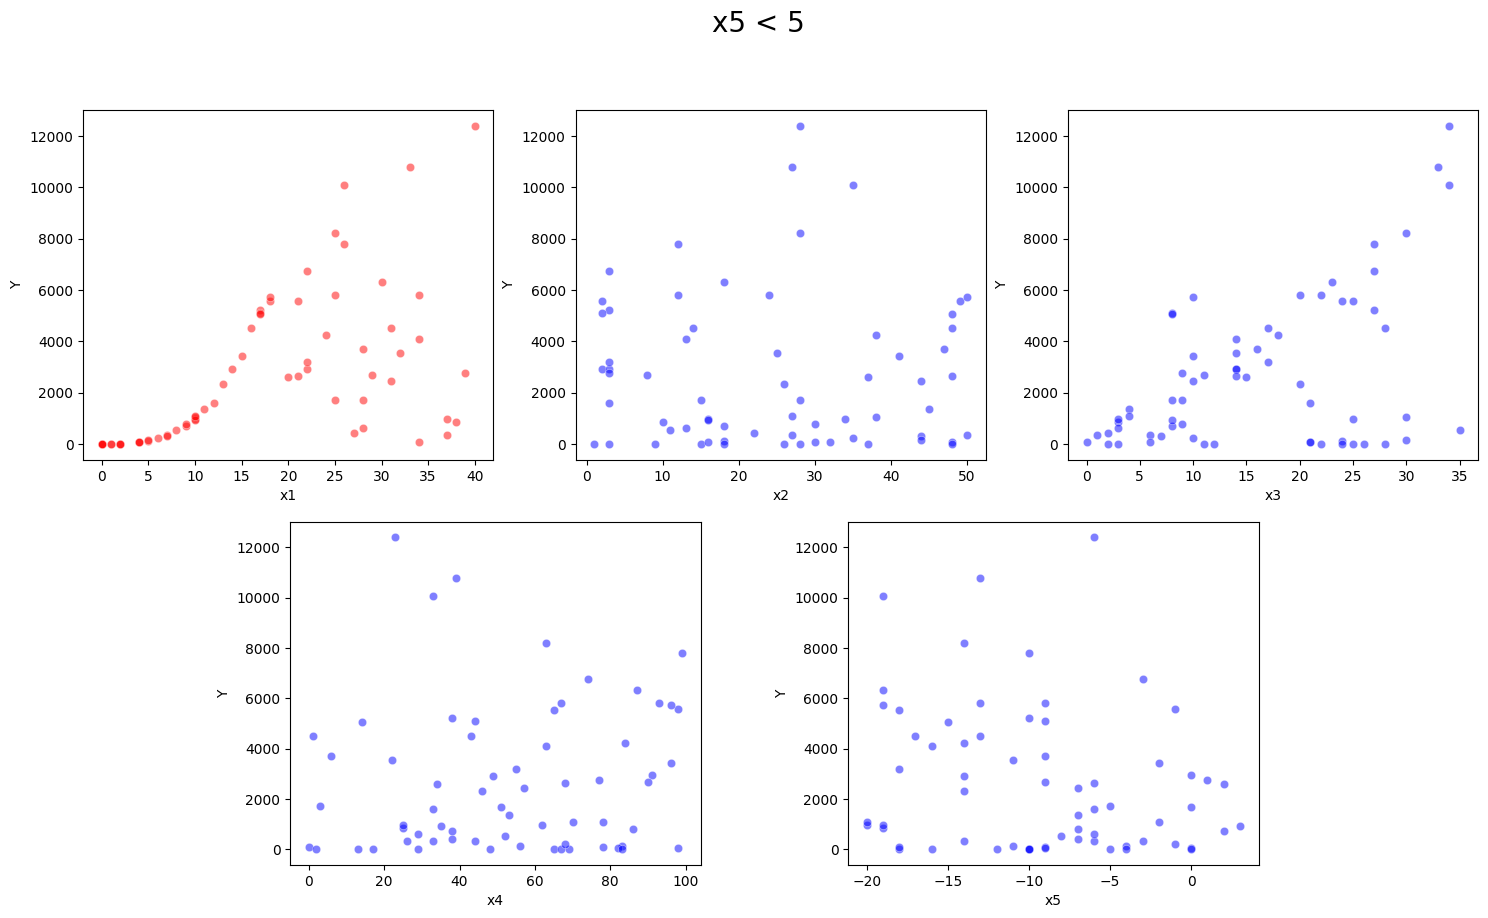

In [409]:
x5_lt, x5_gt = split_by_threshold(dataset, 'x5', threshold=5)
subplot_for_five(data=x5_gt, title='x5 >= 5', highlight=4)
subplot_for_five(data=x5_lt, title='x5 < 5', highlight=0)

Those plots gave me a clear indication that when x5 >= 5, we can apply a linear (or 2nd degree polynomial) regression
line to x5, and it would fit almost perfectly.

What is more interesting is that when x5 does not meet this condition, x1 values that are less than 20 form a 3rd degree
polynomial pattern. So, now I split the remaining data points to also meet this condition.

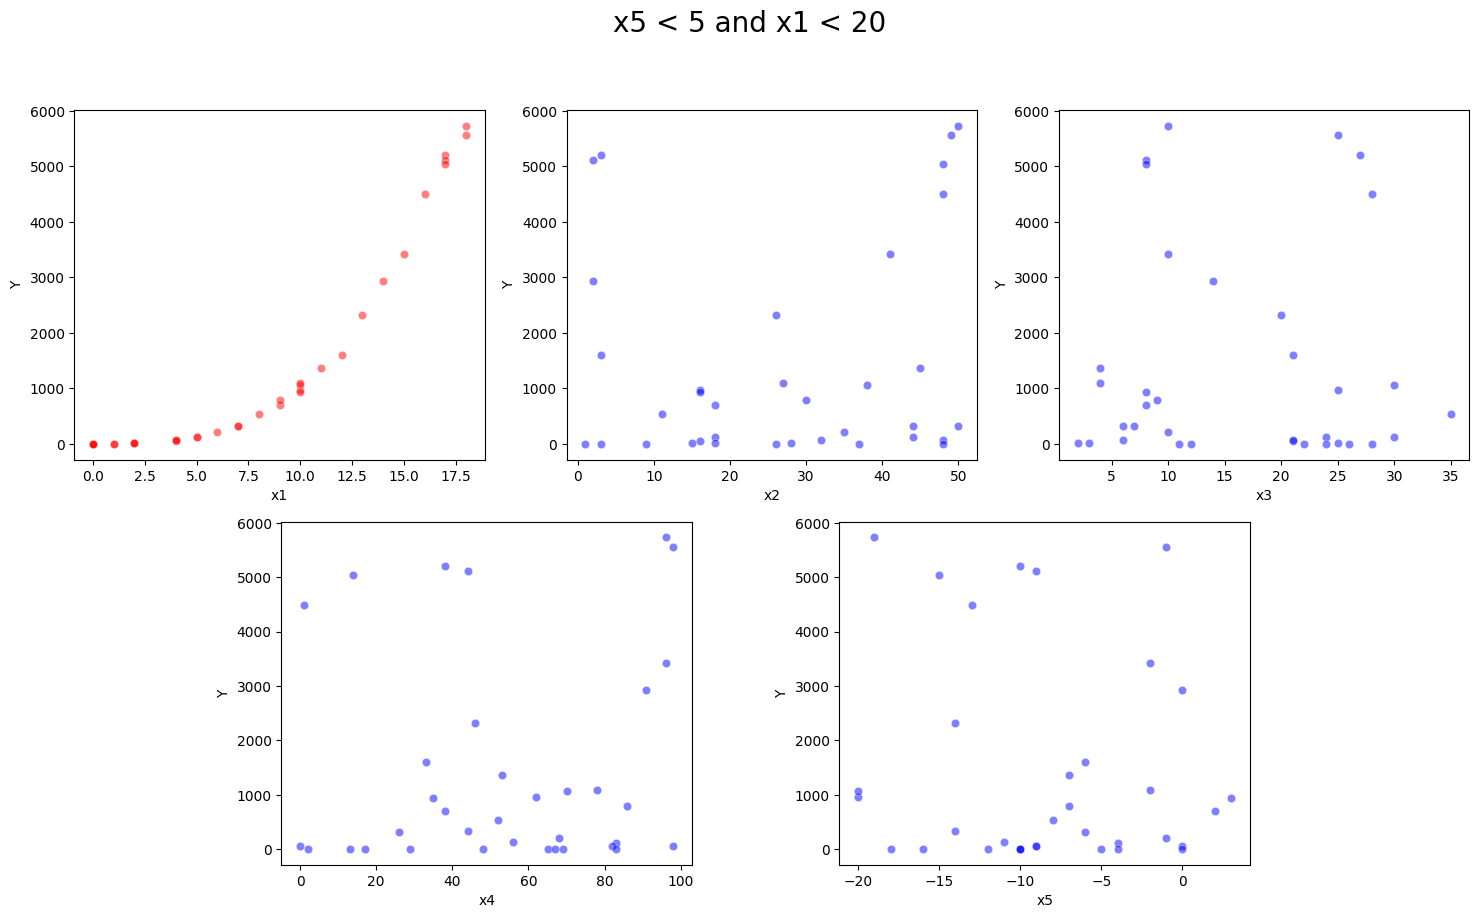

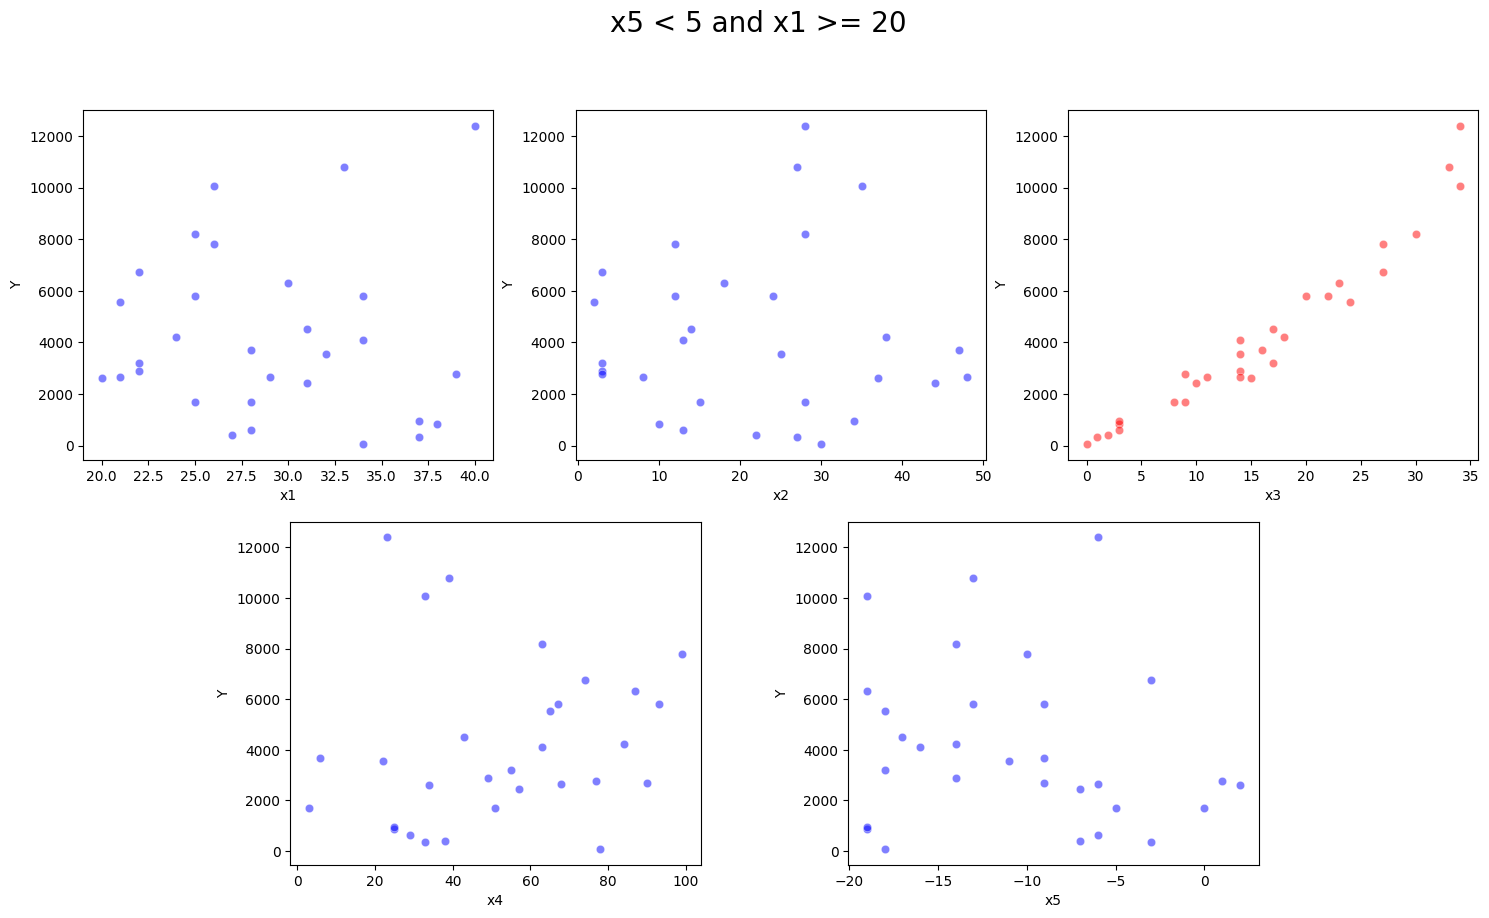

In [410]:
x1_lt, x1_gt = split_by_threshold(x5_lt, 'x1', threshold=20)
subplot_for_five(data=x1_lt, title='x5 < 5 and x1 < 20', highlight=0)
subplot_for_five(data=x1_gt, title='x5 < 5 and x1 >= 20', highlight=2)

As final condition sufficiently fits the points x1 < 20 and x1 >= 20, all outcomes look like the following:

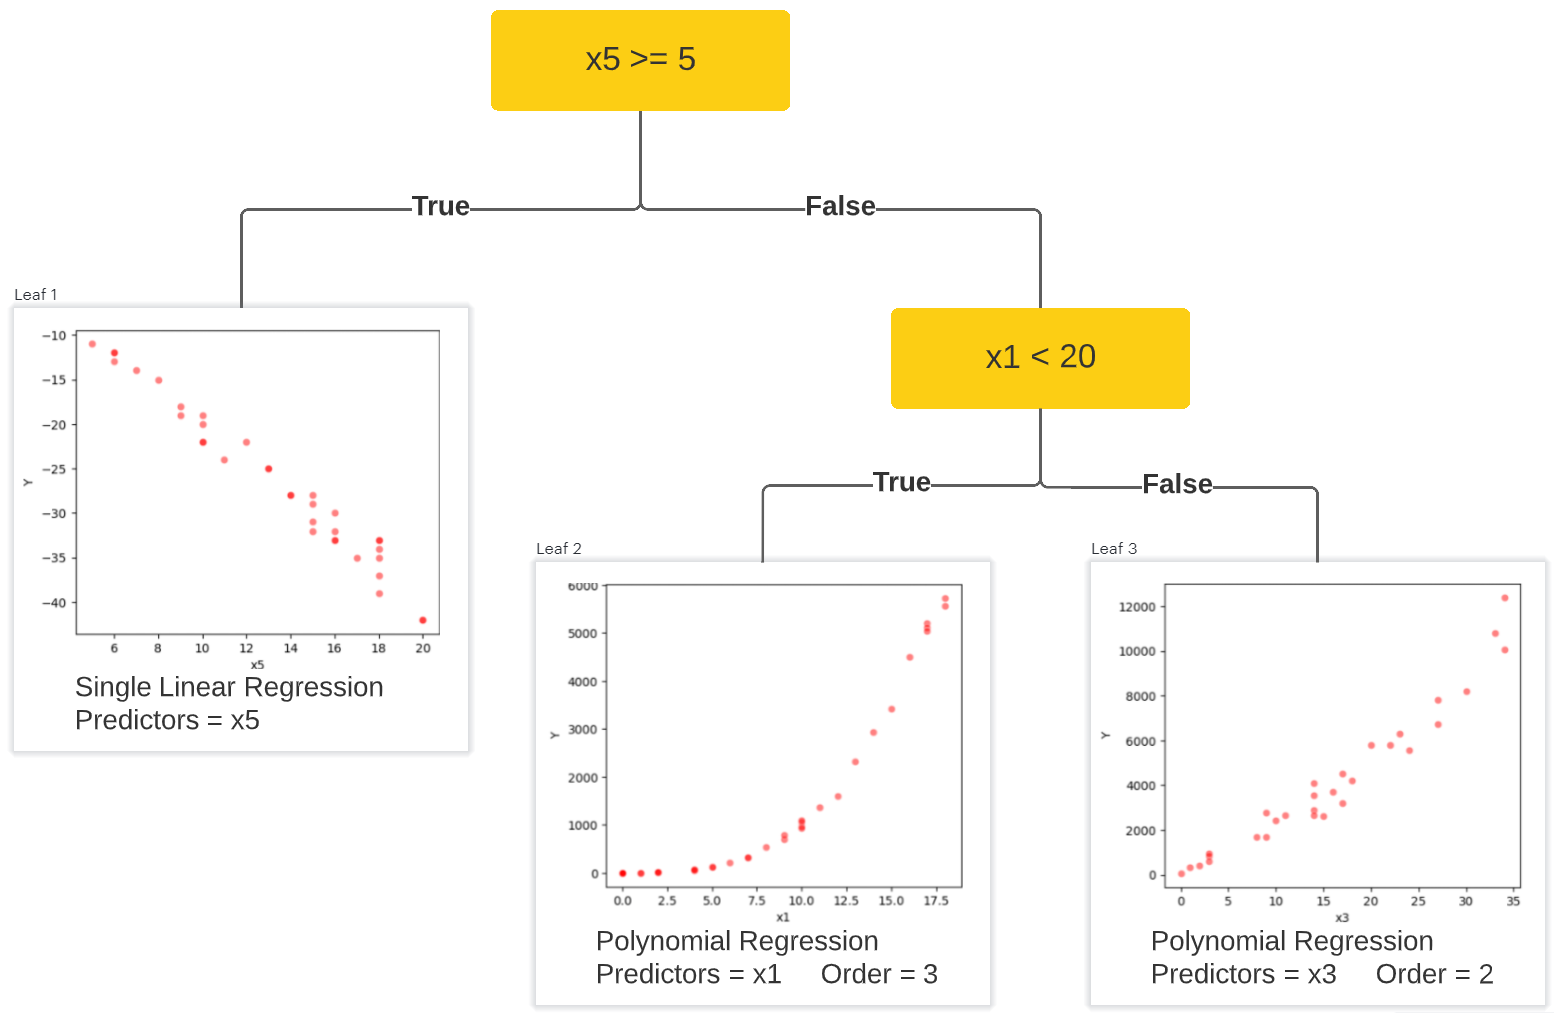

In [411]:
Image(filename='simple_decision_tree.png')

Total CV Score (MAE) = 587.4678528278193


,Model,Predictors,Args,Error
x5>=5,single_linear_regression,[x5],,1.357878
x5<5 && x1<20,polynomial_regression,[x1],order=3,76.824897
x5<5 && x1>=20,polynomial_regression,[x3],order=2,509.285077


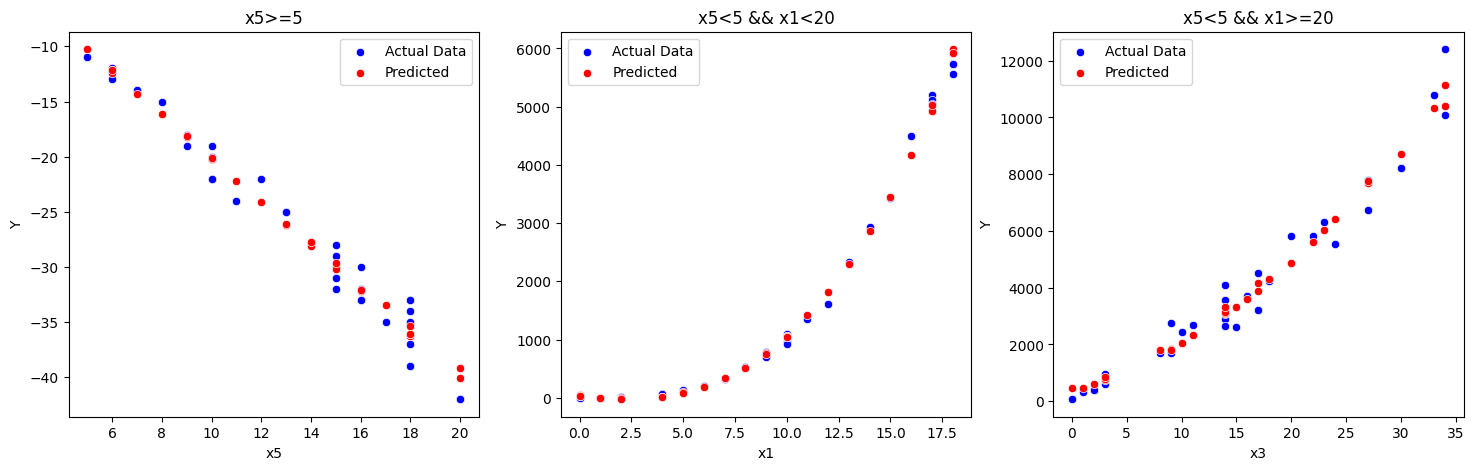

In [412]:
train_conditions = [{'condition': 'x5>5', 'model': single_linear_regression, 'predictors': ['x5'], 'arg': None},
                    {'condition': 'x1<20', 'model': polynomial_regression, 'predictors': ['x1'], 'arg': 3},
                    {'condition': 'x1>20', 'model': polynomial_regression, 'predictors': ['x3'], 'arg': 2}]

decision_models, decision_sets = get_decision_models(dataset, train_conditions, return_sets=True)

titles = ['x5>=5', 'x5<5 && x1<20', 'x5<5 && x1>=20']

plot_conditional_models(cond_models=decision_models,
                        cond_sets=decision_sets,
                        plot_titles=titles)

Cross-validation errors for intervals (x5 >= 5) and (x5 < 5 && x1 < 20) are totally fine. However, when x5 < 5 and
x1 >= 20, data points are sparse and dense time to time. Which means Y should be dependent on some other predictor, as
well as x3.

To find which predictor(s) is the one x3 dependent on, I simply decided to bruteforce it and used cross-validation.

In [413]:
models_df = pd.DataFrame(columns=['Order', 'Predictors'])

predictor_combinations = []
for L in range(2, len(predictors) + 1):
    predictor_combinations.extend(combinations(predictors, L))

for order in range(2, 5):
    for input_predictor in list(map(list, predictor_combinations)):
        target_model = polynomial_regression(x=decision_sets[2][input_predictor],
                                             y=decision_sets[2]['Y'],
                                             inputs=input_predictor, arg=order)
        comp = pd.DataFrame({'Predicted': target_model.predicted, 'Actual': decision_sets[2]['Y']})
        comp['Error'] = (comp['Predicted'] - comp['Actual']).abs()
        models_df.loc[target_model.error] = [order, input_predictor]

models_df.sort_index(inplace=True)
display(models_df)

,Order,Predictors
136.939489,2,"[x1, x3, x4]"
150.079124,2,"[x1, x3]"
155.226960,3,"[x1, x3]"
171.704549,2,"[x1, x3, x5]"
177.354761,2,"[x1, x2, x3]"
...,...,...
32117.258691,4,"[x1, x4, x5]"
36248.339382,3,"[x1, x2, x4, x5]"
37001.932532,4,"[x2, x4, x5]"
75859.656326,4,"[x1, x2, x5]"


Even though predictors [x1, x3, x4] give the best result of MAE = 137, I decided to select [x1, x3] to reduce
dimensionality at the expense of 13 error units.

Total CV Score (MAE) = 228.26189979232612


,Model,Predictors,Args,Error
x5>=5,single_linear_regression,[x5],,1.357878
x5<5 && x1<20,polynomial_regression,[x1],order=3,76.824897
x5<5 && x1>=20,polynomial_regression,"[x3, x1]",order=2,150.079124


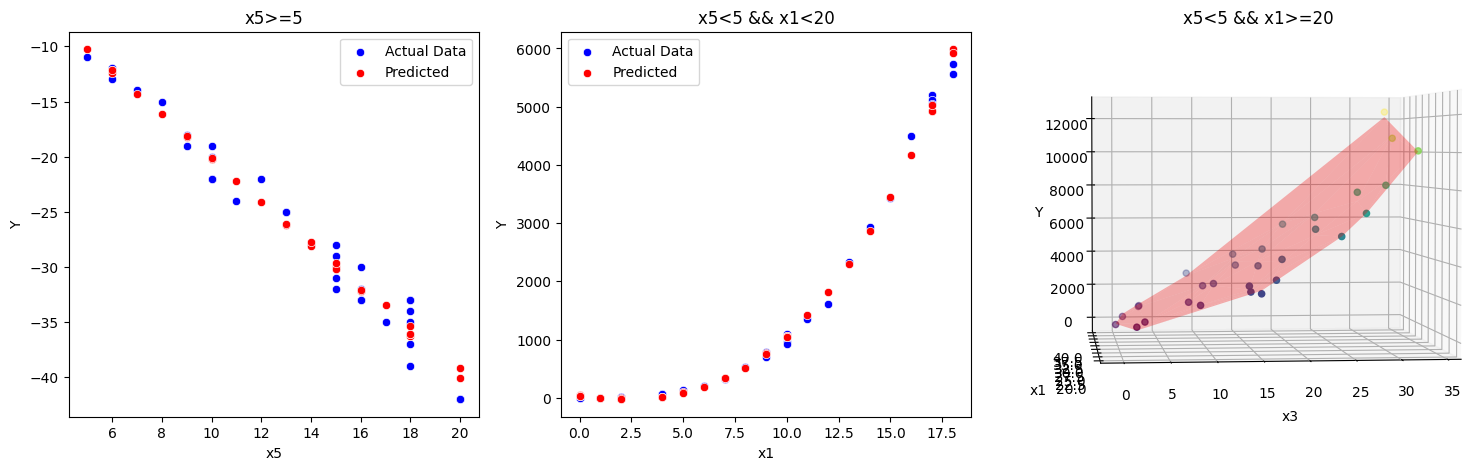

In [414]:
train_conditions[2]['predictors'] = ['x3', 'x1']

decision_models = get_decision_models(dataset, train_conditions)

plot_conditional_models(cond_models=decision_models,
                        cond_sets=decision_sets,
                        plot_titles=titles)

# IV. Scikit-learn Regression Models

## IV.I. Single Linear Regression

,,,,,
predictors,x5,x1,x3,x4,x2
mean_absolute_error,1617.438424,1926.814175,2058.324909,2086.496719,2119.898919


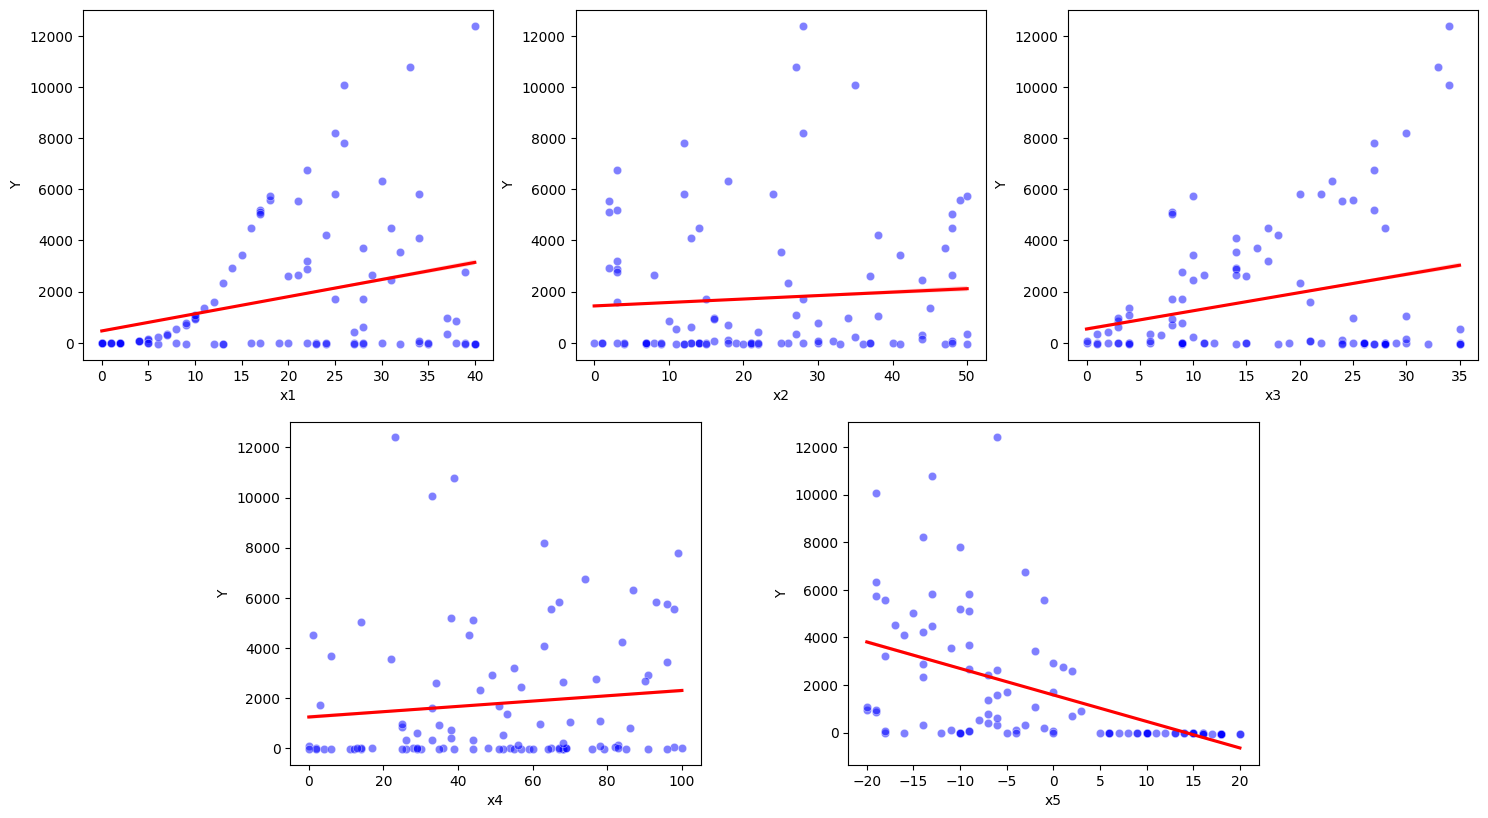

In [415]:
lin_reg_args = predictors
lin_reg_results = [single_linear_regression(x=features[[p]], y=labels, inputs=p) for p in lin_reg_args]

subplot_for_five(dataset, reg_plot=lin_reg_results)

all_results_table.add_model(lin_reg_results)
all_results_table.display_error_table(model='single_linear_regression')

## IV.II. Multiple Linear Regression

In [416]:
predictor_combinations = []
for L in range(2, len(predictors) + 1):
    predictor_combinations.extend(combinations(predictors, L))

multi_lin_reg_args = list(map(list, predictor_combinations))
multi_lin_reg_results = [multiple_linear_regression(x=features, y=labels, inputs=ps) for ps in multi_lin_reg_args]

all_results_table.add_model(multi_lin_reg_results)
all_results_table.display_error_table(model='multiple_linear_regression')

,,,,,,,,,,,...,,,,,,,,,,
predictors,x1 x2 x3 x4 x5,x1 x2 x3 x5,x1 x3 x4 x5,x1 x3 x5,x1 x4 x5,x1 x2 x4 x5,x1 x5,x1 x2 x5,x3 x5,x3 x4 x5,...,x1 x2 x3 x4,x1 x2 x4,x1 x2 x3,x1 x3 x4,x1 x3,x1 x2,x3 x4,x2 x3 x4,x2 x3,x2 x4
mean_absolute_error,1511.917632,1517.509526,1523.633374,1524.508697,1567.465196,1576.544004,1582.768124,1589.458148,1618.960516,1619.27572,...,1911.573541,1916.162649,1918.691638,1927.756342,1930.419838,1931.283869,2050.975378,2051.069142,2056.870792,2095.521641


## IV.III. Polynomial Regression

In [417]:
poly_reg_args = [2, 3, 4]
poly_reg_results = [polynomial_regression(features, labels, arg=order, inputs=predictors) for order in poly_reg_args]

all_results_table.add_model(poly_reg_results)
all_results_table.display_error_table(model='polynomial_regression')

,order=2,order=3,order=4
predictors,"[x1, x2, x3, x4, x5]","[x1, x2, x3, x4, x5]","[x1, x2, x3, x4, x5]"
mean_absolute_error,1090.235941,1847.524961,12615.039421


## IV.IV. K-Nearest-Neighbors Regression

In [418]:
knn_reg_args = range(1, 6)
knn_reg_results = [k_nearest_regression(features, labels, arg=k, inputs=predictors) for k in knn_reg_args]

all_results_table.add_model(knn_reg_results)
all_results_table.display_error_table(model='k_nearest_regression')

,k=2,k=3,k=1,k=4,k=5
predictors,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5
mean_absolute_error,1144.11,1157.616667,1162.46,1254.9675,1300.948


## IV.V. Decision Tree Regression

In [419]:
dec_tree_args = range(1, 6)
dec_tree_results = [decision_tree_regression(features, labels, arg=depth, inputs=predictors) for depth in dec_tree_args]

all_results_table.add_model(dec_tree_results)
all_results_table.display_error_table(model='decision_tree_regression')

,max_depth=5,max_depth=4,max_depth=3,max_depth=2,max_depth=1
predictors,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5
mean_absolute_error,579.674001,641.568172,928.892223,1335.423778,1738.379428


## IV.VI. Random Forest Regression

In [420]:
rf_args = range(1, 6)
rand_forest_results = [random_forest_regression(features, labels, arg=depth, inputs=predictors) for depth in rf_args]

all_results_table.add_model(rand_forest_results)
all_results_table.display_error_table(model='random_forest_regression')

,max_depth=5,max_depth=4,max_depth=3,max_depth=2,max_depth=1
predictors,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5,x1 x2 x3 x4 x5
mean_absolute_error,732.170927,808.027888,1026.834722,1343.349939,1805.692271


# V. Conclusion

In [421]:
all_results_table.display_error_table(transpose=False)

,args,predictors,mean_absolute_error
decision_tree_regression,max_depth=5,x1 x2 x3 x4 x5,579.674001
random_forest_regression,max_depth=5,x1 x2 x3 x4 x5,732.170927
polynomial_regression,order=2,"[x1, x2, x3, x4, x5]",1090.235941
k_nearest_regression,k=2,x1 x2 x3 x4 x5,1144.110000
multiple_linear_regression,,x1 x2 x3 x4 x5,1511.917632
single_linear_regression,,x5,1617.438424


In [422]:
%reload_ext watermark
%watermark -v -m -p sklearn,pandas,numpy,matplotlib,seaborn
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

sklearn   : 1.1.1
pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2
seaborn   : 0.11.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Last updated: Sun Jun 05 2022 17:42:17Turkey Standard Time

